# Predicting Log Error in Zillow
By Qinzhi Chen and Rajesh Lamichhane
<hr style="border-bottom: 10px groove brown; margin-top: 10px; margin-bottom: 10px"></hr>

In [1]:
# team-made modules
import wrangle_final
import model_final
import explore_final
# libraries 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

# Project Overview and Goals
- The Goal of this project is to identify factors affecting deviation of the logerror in the Zillow dataset
- The project uses the Zillow provided dataset and incorporates the regression and clustering methodologies to find out the which feature best predict the logerror
- The project will also utilize the machine learning regression algorithms to create a model that predicts logerror
- The project will also going to to utilize the statistic, hypothesis, and visualization to provide a easy to interpret result

# Wrangle Data (Acquire and Prepare)

In [2]:
# retrive basic information about the data
wrangle_final.zillow_info()

The basic stats about zillow dataframe is:  
                  id      parcelid  airconditioningtypeid  \
count  7.738000e+04  7.738000e+04           24953.000000   
mean   1.495126e+06  1.300715e+07               1.813289   
std    8.609057e+05  3.481368e+06               2.967894   
min    3.490000e+02  1.071186e+07               1.000000   
25%    7.520500e+05  1.153830e+07               1.000000   
50%    1.497870e+06  1.253155e+07               1.000000   
75%    2.240480e+06  1.421184e+07               1.000000   
max    2.982274e+06  1.676893e+08              13.000000   

       architecturalstyletypeid  basementsqft   bathroomcnt    bedroomcnt  \
count                206.000000     50.000000  77380.000000  77380.000000   
mean                   7.388350    679.720000      2.299134      3.053489   
std                    2.734542    689.703546      0.996657      1.139103   
min                    2.000000     38.000000      0.000000      0.000000   
25%                    7.000

#### Steps taken to clean and prepare data
 >- Total of 77380 rows and 68 columns were retrieved.
 >- feature engineered taxrate where taxrate = taxamount/taxvalue
>- feature engineered age column, age = present year - year built
>- renamed columns (bedroomcnt':'bedroom','bathroomcnt':'bathroom','calculatedfinishedsquarefeet':'sqtft',
'taxvaluedollarcnt':'taxvalue','garagecarcnt':'garage','lotsizesquarefeet':'lots','poolcnt':'pool','regionidzip':'zipcode')
 >- nulls: removed columns with more than 40% nulls and rows with more than 50% nulls. 
 >- nulls: dropped all other remaining null
 >- created a new column called county with county names to corresponding to the fips.
 >- created a new column called month corresponding to the month in column transactiondate
 >- dropped columns: transactiondate','heatingorsystemdesc','unitcnt','propertyzoningdesc','lots'
 >- outliers: dropped bathroom count over 5, bedroom count over 8, tax rate over 0.20 and sqtft over 4000


In [3]:
# The acquisition came from a already built module from the team
zillow_train, zillow_validate, zillow_test=wrangle_final.wrangled_file()

In [4]:
# check if the module successfully handled null values
zillow_train.isnull().sum().sum()

0

## Key Takeway
- The module acquire all required data from the SQL database
- The module created a local file after acquired the data
- The module finalized with 70898 rows.
- The module split the data to train (56%), validate(24%), and test(20%)
- The module created a scale function for later use
- The module ended up with 26 columns, with 20 of them are float, 1 int, and 5 ojects
- The module also created four new columns in prepare for the exploration

# Exploration & Clustering

In [5]:
# use module in wrangle final to scale the columns in prepare for clustering and explore
scaled_train,scaled_validate,scaled_test=wrangle_final.scale_data(zillow_train,zillow_validate,zillow_test,cols=['bathroom','bedroom','taxrate','month','age','sqtft'])

In [6]:
# after scaled bathroom, bedroom, taxrate
scaled_train.head(2)

,bathroom,bedroom,calculatedbathnbr,sqtft,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,propertycountylandusecode,...,county,taxrate,month,age,bathroom_scaled,bedroom_scaled,taxrate_scaled,month_scaled,age_scaled,sqtft_scaled
0,1.0,2.0,1.0,1128.0,1128.0,6037.0,1.0,33947371.0,-118157346.0,0100,...,"Los Angeles County, CA",0.012420,7,73.0,0.0,0.250,0.066853,0.750,0.507692,0.253704
1,1.0,3.0,1.0,1252.0,1252.0,6037.0,1.0,34141060.0,-118115780.0,0100,...,"Los Angeles County, CA",0.012178,6,100.0,0.0,0.375,0.065527,0.625,0.715385,0.285937


## Question 1
- Whether there are correlation between sqtft and logerror

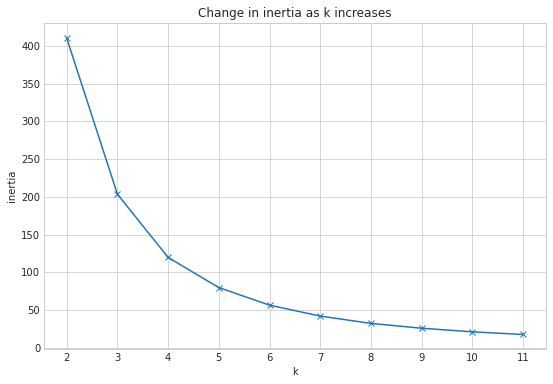

In [7]:
# Find out the best clusters, using sqtft 
explore_final.cluster(scaled_train)

    the optimal value for k is 3

In [8]:
# the scaled version will be added as new columns
scaled_train.head(2)

,bathroom,bedroom,calculatedbathnbr,sqtft,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,propertycountylandusecode,...,taxrate,month,age,bathroom_scaled,bedroom_scaled,taxrate_scaled,month_scaled,age_scaled,sqtft_scaled,cluster
0,1.0,2.0,1.0,1128.0,1128.0,6037.0,1.0,33947371.0,-118157346.0,0100,...,0.012420,7,73.0,0.0,0.250,0.066853,0.750,0.507692,0.253704,2
1,1.0,3.0,1.0,1252.0,1252.0,6037.0,1.0,34141060.0,-118115780.0,0100,...,0.012178,6,100.0,0.0,0.375,0.065527,0.625,0.715385,0.285937,2


## Key Takeaway so far
- The best cluster is three, a new column call cluster created to reflect the finding
- The columns we scaled is sqtft

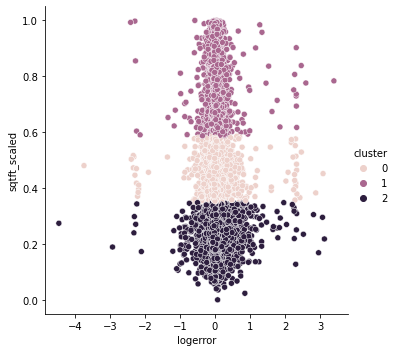

In [9]:
# check the cluster, if we can locate them
sns.relplot(data=scaled_train, 
            x='logerror', 
            y='sqtft_scaled',
           hue='cluster')

## Takeaway from the cluster 
It looks like they could have a cluster labeled, but it doesn't help to answer the question we have here: whether there are correlation between logerror and sqtft

In [10]:
#run pearson's correlation test
corr, p = stats.pearsonr(scaled_train.sqtft_scaled, scaled_train.logerror)
corr, p

(0.02073824307949508, 3.571607788795789e-05)

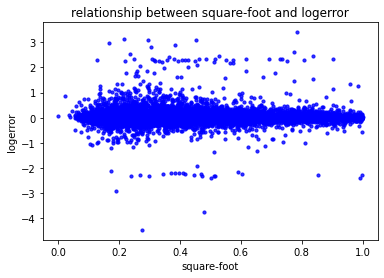

In [11]:
#  plot the test
plt.scatter(scaled_train.sqtft_scaled, scaled_train.logerror, s=10, c='blue', alpha=.8)
plt.xlabel("square-foot")
plt.ylabel("logerror")
plt.title("relationship between square-foot and logerror")
plt.show()

## Takeaway from stat correlation test
- The correlation between the sqtft and logerror are very minimal.
- The sqtft probably doesn't play significant role in this situation
- Further investigation needed.

## Question 1 Takeaway
- The sqtft doesn't play high correlation role with logerror, but the cluster showed similar object in dataset, vertically.
- The next question show focus on whether the bedroom and bathroom have significant role with logerror

# Question 2
- Whether the bedroom, bathroom, and logerror have significant relationship

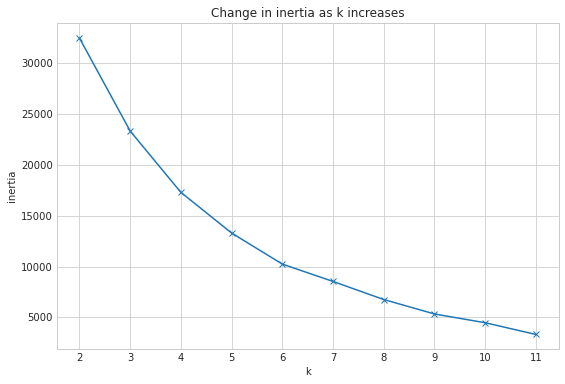

In [12]:
# put them into test.
explore_final.cluster2(scaled_train)

    optimal k is 4 

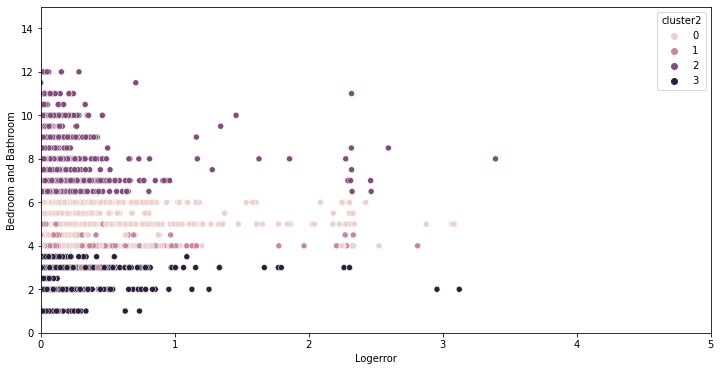

In [13]:
#add bathroom and bedroom into new column called rooms
#plot rooms vs logerror
scaled_train['rooms']=scaled_train.bathroom+scaled_train.bedroom
plt.figure(figsize=(12,6))
sns.scatterplot(y=scaled_train.rooms,x=scaled_train.logerror, hue=scaled_train.cluster2)
plt.xlabel("Logerror")
plt.ylabel("Bedroom and Bathroom")
plt.ylim(0, 15)
plt.xlim(0, 5)
plt.show()

## Cluster takeaway
- The grouping in this cluster is not obvious between 4 and 8 rooms, but we can identify that as the room increase, the cluster grouping is obvious

In [14]:
#run pearson's correlation test
corr, p = stats.pearsonr(scaled_train.rooms, scaled_train.logerror)
corr, p

(0.02769312218153005, 3.384241240205612e-08)

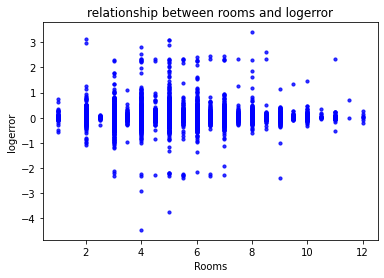

In [15]:
#  plot the test
plt.scatter(scaled_train.rooms, scaled_train.logerror, s=10, c='blue', alpha=.8)
plt.xlabel("Rooms")
plt.ylabel("logerror")
plt.title("relationship between rooms and logerror")
plt.show()

    The correlation between rooms and logerror is .027, which is not significant.

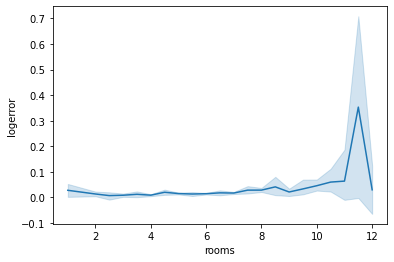

In [16]:
#visualise rooms vs logerror
sns.lineplot(data=scaled_train, x = 'rooms' ,y= 'logerror')
plt.show()

## Question 2 Key takeway
- The result is that the bedroom and bathroom doesn't have significant role in logerror
- the cluster also didn't show any significant grouping 
- we believe there should be some relationship between bedroom, bathroom, and logerror, but it is not significant enough to identify it 
- There will be high logerror when the room are increasing from 10 to 12, but further investigation needed.

# Question 3
- whether the county has similar logerror

In [70]:
# make subset of logerror by counties
orange = scaled_train[scaled_train.county == 'Orange County, CA'].logerror
ventura = scaled_train[scaled_train.county == 'Ventura County, CA'].logerror
LA = scaled_train[scaled_train.county == 'Los Angeles County, CA'].logerror

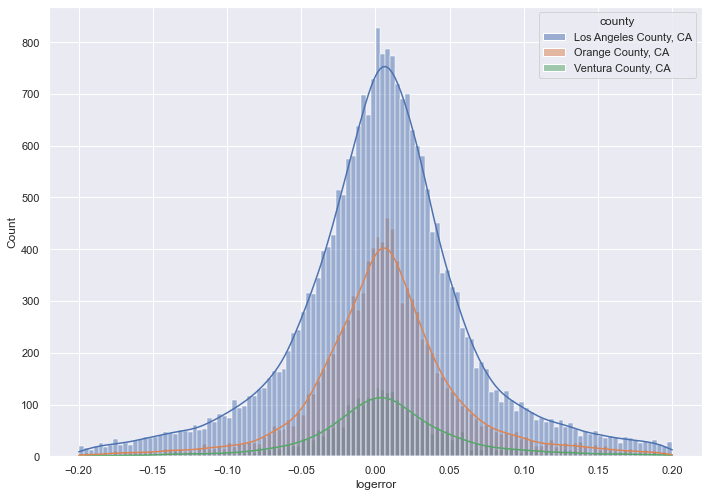

In [96]:
#visualise logerror in different counties
zx=scaled_train[scaled_train.logerror<=.2]
nzx=zx[zx.logerror>=-.2]
rc=sns.histplot(x=nzx.logerror,hue='county',data=nzx,kde=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
#variance check
LA.var(),orange.var(),ventura.var()

In [20]:
#anova test set up
# H0=there are no difference between counties in logerror
# Ha= There are difference between counties in logerror

alpha = 0.05

F, p = stats.f_oneway(orange, ventura, LA)

print('Anova Test Results on county')
print('F-value: ',F)
print('p-value: ',p)
if p > alpha:
    print("\nWe fail to reject null hypothesis.")

else:
    print("We reject null hypothesis\n\n")

Anova Test Results on county
F-value:  4.498773211057824
p-value:  0.011128301318917455
We reject null hypothesis




## Question 3 Key Takeaway
- The logerrors are different in different county
- The hist shows that the ventura has more likely to have negative logerror while the orange and LA are more central
- The hypothesis with ANOVA variable analysis revealed that the orange county has higher variable than other two counties


# Question 4
- Whether the logerror and age could have significant group

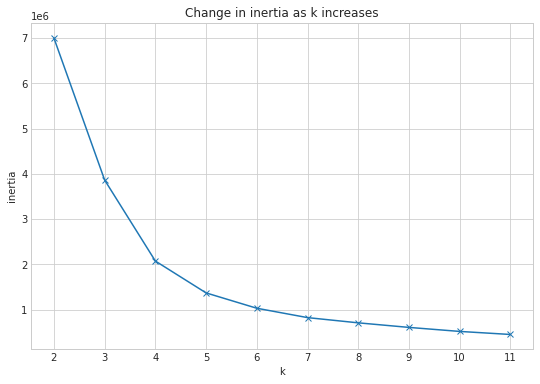

In [21]:
#visualise elbow mehtod
explore_final.cluster3(scaled_train)

    optimal k is 3

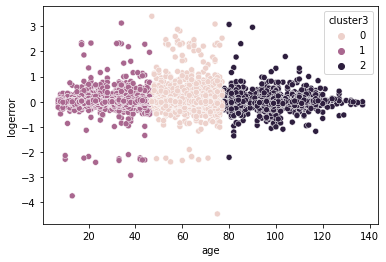

In [22]:
#visualise clusters in age and logerror
sns.scatterplot(y = 'logerror', x= 'age', data = scaled_train, hue = 'cluster3')
plt.show()

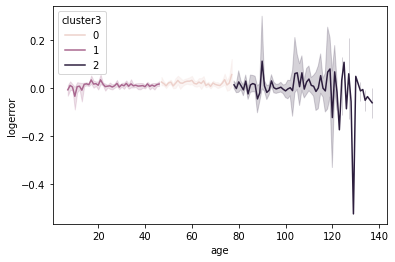

In [23]:
#visualise lineplot of age and logerror using clusters
sns.lineplot(data=scaled_train, x = 'age' ,y= 'logerror', hue='cluster3')
plt.show()

## Question 4 Key takeaway
- The age illustrated a similar trend with the sqtft (ref. question 1).
- However, the logerror are more likely to show positive trend when it is older than 80 years old .
- After 120 years old, the house will show significant negative logerror and positive logerror
- The likelyhood for the logerror to show positive is higher than likelyhood to show negative when the age is under 80

# Exploration Summary
- The exploration took place with 3 hypothesis tests, and three clustering, and more than 9 visualizations
- The exploration revealed that the house age has played significant role in logerror after 80 years.
- The exploration also revealed that the house in Orange County has significant variance compare to the other counties
- The exploration revealed that the Ventura county is more likely to have negative log error compare to the other two counties
- The exploration found that the logerror will increase when the room numbers increase to 9
- The grouping in this cluster is not obvious between 4 and 8 rooms, but we can identify that as the room increase the cluster grouping is obvious

# Modeling

In [24]:
#create baseline and split data into x_y train, validate, and test
x_train, y_train,x_validate,y_validate,x_test,y_test=model_final.x_y_split(zillow_train,zillow_validate,zillow_test)
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test=pd.DataFrame(y_test)
y_train['baseline'] = y_train['logerror'].mean()
y_validate['baseline'] = y_validate['logerror'].mean()
y_test['baseline']=y_test['logerror'].mean()

In [25]:
# dataframe the modle with RMSE and R square.
# the table below is baline model
# the table created by a function existed in model_final.py
models=model_final.models(y_train)
models

,model,rmse,r^2
0,baseline,0.15743,0.0


In [26]:
#use LassoLar model
models=models.append(model_final.modeling_train(LassoLars(alpha=1.0), 
                  x_train, 
                  y_train, 
                  x_validate, 
                  y_validate, 
                  scores=models), ignore_index=True)

model name?LAR


In [27]:
#use linear regression model
models=models.append(model_final.modeling_train(LinearRegression(normalize=True), 
                  x_train, 
                  y_train, 
                  x_validate, 
                  y_validate, 
                  scores=models), ignore_index=True)

model name?LinearRegression


In [28]:
#use kbest model
kbest = SelectKBest(f_regression, k=3)
kbest.fit(x_train, y_train.logerror)
mask = x_train.columns[kbest.get_support()].to_list()
models=models.append(model_final.modeling_train(LinearRegression(), 
                  x_train[mask], 
                  y_train, 
                  x_validate[mask], 
                  y_validate, 
                  scores=models), ignore_index=True)

model name?Kbest


In [29]:
#use polynomial feature model
scaler=MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), index=x_train.index, columns=x_train.columns)
x_validate_scaled = pd.DataFrame(scaler.fit_transform(x_validate), index=x_validate.index, columns=x_validate.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test), index=x_test.index, columns=x_test.columns)
polyfeats = PolynomialFeatures(degree=2)
x_train_quad = polyfeats.fit_transform(x_train_scaled)
x_val_quad = polyfeats.transform(x_validate_scaled)
models = models.append(model_final.modeling_train(LinearRegression(), 
                  x_train_quad, 
                  y_train, 
                  x_val_quad, 
                  y_validate, 
                  scores=models), ignore_index=True)

model name?Poly


In [30]:
#compare the models
models
# The best model is Polynominal, which we will run a validate on it in our next code

,model,rmse,r^2
0,baseline,0.157430,0.000000
1,LAR,0.157430,0.000000
2,LinearRegression,0.157183,0.003144
3,Kbest,0.157273,0.001998
4,Poly,0.156681,0.009507


In [31]:
# use in validate 
# the Polinominal regression model
scaler=MinMaxScaler()
x__train_scaled = pd.DataFrame(scaler.fit_transform(x_train), index=x_train.index, columns=x_train.columns)
x_validate_scaled = pd.DataFrame(scaler.fit_transform(x_validate), index=x_validate.index, columns=x_validate.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test), index=x_test.index, columns=x_test.columns)
polyfeats = PolynomialFeatures(degree=2)
x_train_quad = polyfeats.fit_transform(x_train_scaled)
x_val_quad = polyfeats.transform(x_validate_scaled)
models = models.append(model_final.modeling_validate(LinearRegression(), 
                  x_train_quad, 
                  y_train, 
                  x_val_quad, 
                  y_validate, 
                  scores=models), ignore_index=True)

model name?Poly_V


In [32]:
# the result of the polynominal in validate is not optimal, but we will move forward with it on our test
models

,model,rmse,r^2
0,baseline,1.574302e-01,0.000000e+00
1,LAR,1.574302e-01,0.000000e+00
2,LinearRegression,1.571825e-01,3.144355e-03
3,Kbest,1.572729e-01,1.998107e-03
4,Poly,1.566806e-01,9.506772e-03
5,Poly_V,9.911032e+08,-1.754005e+19


In [33]:
# the test result with our polynominal model
x_test_quad = polyfeats.transform(x_test_scaled)
models = models.append(model_final.modeling_test(LinearRegression(), 
                  x_test_quad, 
                  y_test,  
                  scores=models), ignore_index=True)

model name?Poly_T


In [37]:
# Polynominal has the .021 r squre result, which is significant high compare to the original training set
models[models.model=='Poly_T']

,model,rmse,r^2
6,Poly_T,0.15748,0.02091


## Modeling Takeaway
- The best performed model is Polynominal with two degree with achieved 0.02091 R Square result
- The polynominal achieved 0.15748 on RMSE 

# Recommendation, Next Step, and Conclusion

#### Recommendation
- All models performed better than the baseline, even if not by much. we do recommend to use the polynominal model, due to its outperformance on the training set. The later test revealed that it achieved .021 R Square result. Also we recommend that we need better data, due to the month ended with september, we are missing 3 more month worth of data. And roughly half of all features are lost due to missing too many values which reduces the number of potential drivers of logerror we could analyze. Clustering was shown to be a useful exercise, so additional clustering exploration is recommended in an attempt to find clusters that serve as larger drivers.

#### Next Step
- We need to gather data from the October, November, and December
- We need more data from those missing values that exceed 40%, which significantly located in Orange County and Ventura County. They are not good counties :(.

#### Conclusion
- The exploration took place with 3 hypothesis tests, and three clustering, and more than 9 visualizations
- The exploration revealed that the house age has played significant role in logerror after 80 years.
- The exploration also revealed that the house in Orange County has significant variance compare to the other counties
- The exploration revealed that the Ventura county is more likely to have negative log error compare to the other two counties
- The exploration found that the logerror will increase when the room numbers increase to 9
- The grouping in this cluster is not obvious between 4 and 8 rooms, but we can identify that as the room increase the cluster grouping is obvious
- The modeling we selected is the polynominal modeling with two degree, which achieved 0.15748 RMSE and .02091 Rsquare.